# Task 

Steps 
- Step 1 : we add noise(0.5) to the input image, and denoise it:
once conditioned on the query text(zebra), and once conditioned on a reference text(horse) (or unconditionally).
- Step 2 : Derive the mask by subtracting the 2 latents and binarize it 
- Step 3 : Add noise to the original image with unconditional prompt

- Step 4: Only do stable diffusion on masked area and replace the pixles of unmasked area with values from step 3

![DiffEdit Paper](https://raw.githubusercontent.com/Xiang-cd/DiffEdit-stable-diffusion/master/assets/paper.png)


# Imports 

In [4]:
!pip install -q --upgrade transformers==4.33.1 diffusers ftfy accelerate

In [5]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(42)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

# Loading in the models

In [8]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

# The Diffusion loop ( For refrence ) 

# DiffEdit

## Opening image and converting it to latent space

In [9]:
!curl --output horsey.jpg 'https://images.pexels.com/photos/6403445/pexels-photo-6403445.jpeg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2762k  100 2762k    0     0  12.2M      0 --:--:-- --:--:-- --:--:-- 12.2M


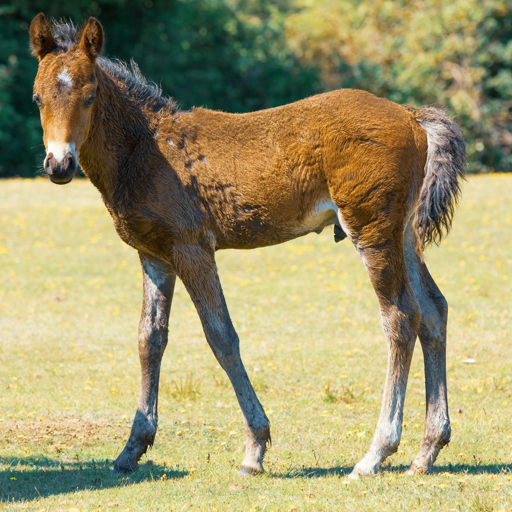

In [10]:
input_image = Image.open('/kaggle/working/horsey.jpg').resize((512, 512))
input_image

### AutoEncoder (VAE)

In [11]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [12]:
encoded = pil_to_latent(input_image)
encoded.shape

torch.Size([1, 4, 64, 64])

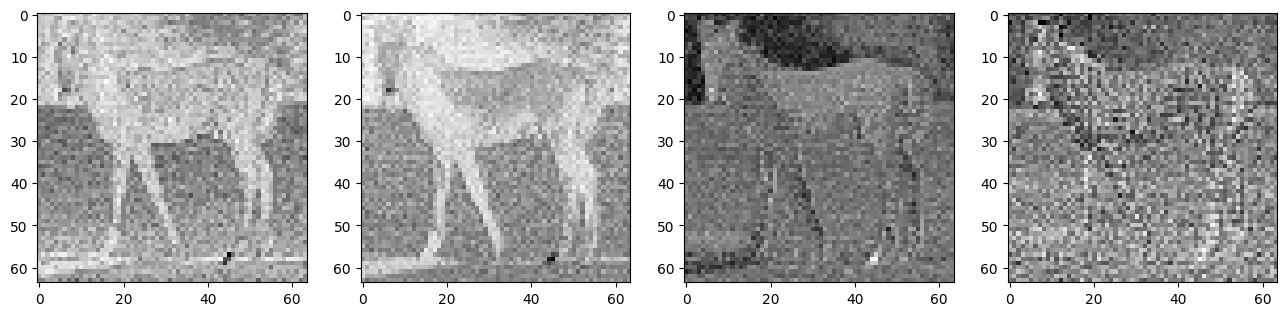

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(encoded[0][c].cpu(), cmap='Greys')

## Step 1 : we add noise(0.5) to the input image, and denoise it:


In [14]:
# Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925


In [15]:
set_timesteps(scheduler, 50)

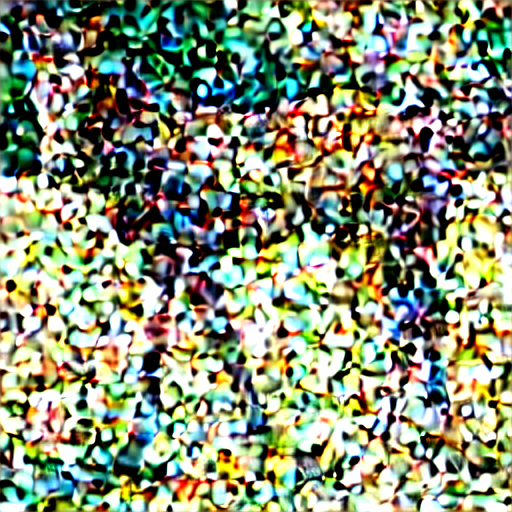

In [16]:
noise = torch.randn_like(encoded) # Random noise
sampling_step = 25 # Equivalent to step 10 out of 15 in the schedule above
# encoded_and_noised = scheduler.add_noise(encoded, noise, timestep) # Diffusers 0.3 and below
encoded_and_noised = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[sampling_step]]))
latents_to_pil(encoded_and_noised.float())[0] # Display

In [17]:
# Some settings


In [18]:
def display(latents):
    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample

    # Display
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    pil_images[0]
    return pil_images[0]

In [19]:
def prep_text(prompts):
        text_embeddings = []
        text_input = tokenizer(prompts[0], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
        with torch.no_grad():
            text_embedding = text_encoder(text_input.input_ids.to(torch_device))[0]
        max_length = text_input.input_ids.shape[-1]
        uncond_input = tokenizer(
        prompts[1] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")

        with torch.no_grad():
            uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
        return (torch.cat([uncond_embeddings, text_embedding]))


In [20]:
def prepLatents(height,width,t=0):
    noise = torch.randn_like(encoded)
    latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[t]]))
    latents = latents.to(torch_device)
    return latents

In [30]:

set_timesteps(scheduler,100)
batch_size = 1
text_embeddings = prep_text(["Mule","Horse"])
t = 50
latents = prepLatents(512,512,t)


input_latents = torch.cat([latents]*2)
input_latents = scheduler.scale_model_input(input_latents, scheduler.timesteps[t])
    
with torch.no_grad(): 
    pred = unet(input_latents, scheduler.timesteps[t], encoder_hidden_states= text_embeddings).sample
    pred_noise_q , pred_noise_r = pred.chunk(2)
    mask = (pred_noise_q - pred_noise_r).abs().mean(1) 

    

## Step 2 : Derive the mask by subtracting the 2 latents and binarize it 


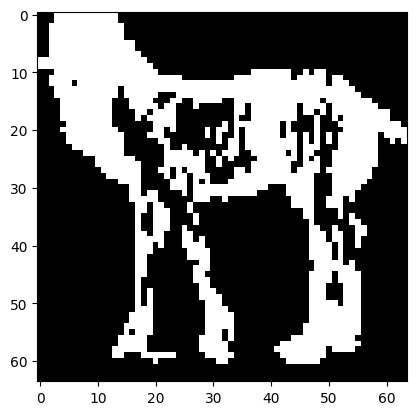

In [33]:
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2 as cv

# Normalizing the mask values
mask_b = (mask - mask.mean((-1,-2)))/mask.std((-1,-2))
mask_b = mask_b.cpu().numpy()

#Applying blur to smooth the mask 
blur = cv.GaussianBlur(mask_b,(3,3),0)
mask_b = torch.tensor(blur*4).to(torch_device)

#Thresholding
mask_b = mask_b > 0.1
#plt.imshow(blur[0], cmap='gray')
plt.imshow(mask_b[0].detach().cpu(), cmap='gray')

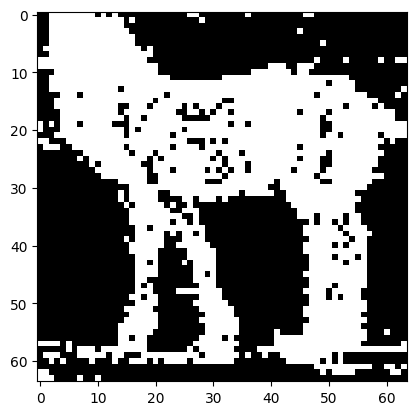

In [37]:
maska = mask > 0.007
plt.imshow(maska[0].detach().cpu(), cmap='gray')

## Step 3 : Add noise to the original image with unconditional prompt


In [38]:
num_inference_steps = 100
encoding_ratio = 0.8

In [39]:
scheduler.set_timesteps(num_inference_steps)

# Prep latents (noising appropriately for start_step)
start_step = int(num_inference_steps*(1-encoding_ratio))
print(start_step)
start_sigma = scheduler.sigmas[start_step]


noise = torch.randn_like(encoded)
st2_latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor(scheduler.timesteps[start_step:]))
st2_latents = st2_latents.to('cpu').float()
st2_latents.shape

19


/tmp/ipykernel_34/466197137.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  st2_latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor(scheduler.timesteps[start_step:]))


torch.Size([81, 4, 64, 64])

  0%|          | 0/100 [00:00<?, ?it/s]

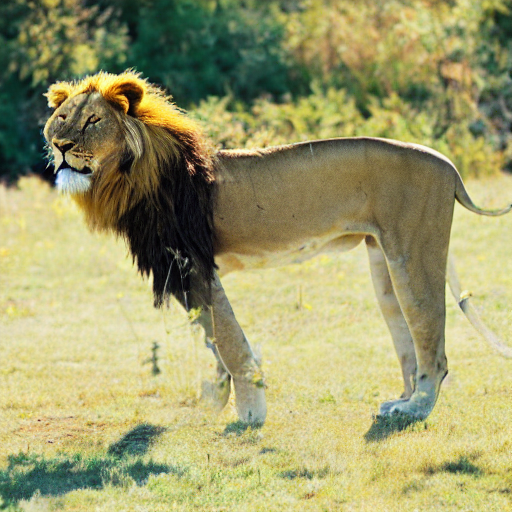

In [47]:
# Settings (same as before except for the new prompt)
prompt = ["Lion"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 100            # Number of denoising steps
guidance_scale = 8                  # Scale for classifier-free guidance
generator = torch.manual_seed(1)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text (same as before)
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler (setting the number of inference steps)
set_timesteps(scheduler, num_inference_steps)


# Prep latents (noising appropriately for start_step)

latent1 = st2_latents[0].to(torch_device)[None,:]

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    if i >= start_step: # << This is the only modification to the loop we do

        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latent1] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latent1 = scheduler.step(noise_pred, t, latent1).prev_sample
        if (i < len(scheduler.timesteps)-20):
            latent1 = maska * latent1 + (~maska)*st2_latents[i-start_step].to(torch_device)

latents_to_pil(latent1)[0]

## Best Results I got 

![Original](orignal.png)

![Edit1](Edit1.png)

![Edit2](edit2.png)